## Task II - Estimating Service Metrics from Device Statistics
### EQ 2420 - Network Analytics

Ruihan Zhang
Nov 8, 2022

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn.ensemble
import sklearn.metrics
print('pandas =', pd.__version__)
print('numpy =', np.__version__)

select_KV = np.load('select_KV.npy')
select_VoD = np.load('select_VoD.npy')

X_KV = pd.read_csv('./JNSM_KV_flashcrowd_2/X.csv').drop(columns=['TimeStamp','Unnamed: 0']).iloc[:,select_KV]
Y_KV = pd.read_csv('./JNSM_KV_flashcrowd_2/Y.csv')['ReadsAvg']

X_VoD = pd.read_csv('./JNSM_VoD_flashcrowd_2/X.csv').drop(columns=['TimeStamp','Unnamed: 0']).iloc[:,select_VoD]
Y_VoD = pd.read_csv('./JNSM_VoD_flashcrowd_2/Y.csv')['DispFrames']

pandas = 1.4.4
numpy = 1.23.4


In [3]:
# selecting the top features using random forest.
def select_feature(X, Y, num=16):
    regr = sklearn.ensemble.RandomForestRegressor(max_depth=500, n_jobs=-1, verbose=1)
    regr.fit(X, Y)
    return np.argsort(regr.feature_importances_)[-num:]

In [2]:
select_KV = select_feature(X_KV, Y_KV)
select_VoD = select_feature(X_VoD, Y_VoD)

NameError: name 'select_feature' is not defined

In [41]:
# save the result
np.save("select_KV", select_KV)
np.save("select_VoD", select_VoD)

In [3]:
select_KV = np.load('select_KV.npy')
select_VoD = np.load('select_VoD.npy')
print(X_KV.columns[sorted(select_KV)])
print(X_VoD.columns[sorted(select_KV)])

IndexError: index 134 is out of bounds for axis 0 with size 16

In [5]:
# draw ramdom samples from the dataset to form training set and test set
# X_KV_train = X_KV.iloc[:,select_KV].sample(frac=0.7)
# X_KV_test = X_KV.iloc[:,select_KV].drop(X_KV_train.index)
# Y_KV_train = Y_KV.iloc[X_KV_train.index,:]
# Y_KV_test = Y_KV.iloc[X_KV_test.index,:]

# X_VoD_train = X_VoD.iloc[:,select_VoD].sample(frac=0.7)
# X_VoD_test = X_VoD.iloc[:,select_VoD].drop(X_VoD_train.index)
# Y_VoD_train = Y_VoD.iloc[X_VoD_train.index,:]
# Y_VoD_test = Y_VoD.iloc[X_VoD_test.index,:]

from sklearn.model_selection import train_test_split

X_KV_train, X_KV_test, Y_KV_train, Y_KV_test = train_test_split(X_KV, Y_KV, test_size=0.3)

X_VoD_train, X_VoD_test, Y_VoD_train, Y_VoD_test = train_test_split(X_VoD, Y_VoD, test_size=0.3)

In [7]:
# our evaluating metric: Normalized Mean Absolute Error
def NMAE(y_true, y_pred):
    return abs(y_true - y_pred).mean() / abs(y_pred.mean())

In [8]:
# Linear regression model
def linear_predict(X, Y, Xtest):
    theta = np.linalg.inv( X.T @ X ) @ X.T @ Y
    return Xtest @ theta

In [13]:
from sklearn import linear_model
reg = linear_model.LinearRegression()
reg.fit(X_KV_train,Y_KV_train)
Y_KV_pred = reg.predict(X_KV_test)
print( NMAE(Y_KV_test.values, Y_KV_pred) )
sklearn.metrics.r2_score(Y_KV_test.values, Y_KV_pred)

0.0217527339980307


0.49690806459044645

In [14]:
reg = linear_model.LinearRegression()
reg.fit(X_VoD_train,Y_VoD_train)
Y_VoD_pred = reg.predict(X_VoD_test)
print( NMAE(Y_VoD_test.values, Y_VoD_pred) )
sklearn.metrics.r2_score(Y_VoD_test.values, Y_VoD_pred)

0.12123686547977217


0.25870139896040323

In [15]:
# Naive method, using mean as estimation:
Y_KV_pred = Y_KV_train.values.mean(axis=0)
print( NMAE(Y_KV_test.values, Y_KV_pred) )

0.04176517237956494


In [16]:
Y_VoD_pred = Y_VoD_train.values.mean(axis=0)
print( NMAE(Y_VoD_test.values, Y_VoD_pred) )

0.1456337043019516


In [17]:
# random forest regression
def random_forest(X, Y, Xtest):
    regr = sklearn.ensemble.RandomForestRegressor(random_state=0, n_jobs=-1)
    regr.fit(X, Y)
    print(regr.get_params())
    return regr.predict(Xtest)

In [47]:
Y_KV_pred = random_forest(X_KV_train.values, Y_KV_train.values, X_KV_test.values)
print( 'nmae is', NMAE(Y_KV_test.values, Y_KV_pred) )
print('r2 is:', sklearn.metrics.r2_score(Y_KV_test.values, Y_KV_pred))

{'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': -1, 'oob_score': False, 'random_state': 0, 'verbose': 0, 'warm_start': False}
nmae is 0.02015985632175413
r2 is: 0.5740090804538682


In [19]:
Y_VoD_pred = random_forest(X_VoD_train.values, Y_VoD_train.values, X_VoD_test.values)
print( NMAE(Y_VoD_test.values, Y_VoD_pred) )
sklearn.metrics.r2_score(Y_VoD_test.values, Y_VoD_pred)

{'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': -1, 'oob_score': False, 'random_state': 0, 'verbose': 0, 'warm_start': False}
0.06258437684276251


0.6083924872142177

In [50]:
# neural network KV
from sklearn.neural_network import MLPRegressor
regr = MLPRegressor(hidden_layer_sizes=(10, 10, 10 ,10, 10), max_iter=5000, learning_rate_init=0.0001)
regr.fit(X_KV_train, Y_KV_train)
Y_KV_pred = regr.predict(X_KV_test)
print(regr.score(X_KV_test, Y_KV_test))
print( 'nmae is', NMAE(Y_KV_test.values, Y_KV_pred) )
print('r2 is:', sklearn.metrics.r2_score(Y_KV_test.values, Y_KV_pred))

-1.3789013153404253
nmae is 0.026096239871923478
r2 is: -1.3789013153404253


In [52]:
# neural network VoD
from sklearn.neural_network import MLPClassifier
regr = MLPClassifier(hidden_layer_sizes=(16,16,16,16,16,16,16), max_iter=5000, learning_rate_init=0.0001)
regr.fit(X_VoD_train, Y_VoD_train)
Y_VoD_pred = regr.predict(X_VoD_test)
print(regr.score(X_VoD_test, Y_VoD_test))
print( 'nmae is', NMAE(Y_VoD_test.values, Y_VoD_pred) )
print('r2 is:', sklearn.metrics.r2_score(Y_VoD_test.values, Y_VoD_pred))

0.792952380952381
nmae is 0.08385714285714285
r2 is: -0.2142664639860774


AttributeError: '_iLocIndexer' object has no attribute 'mean'

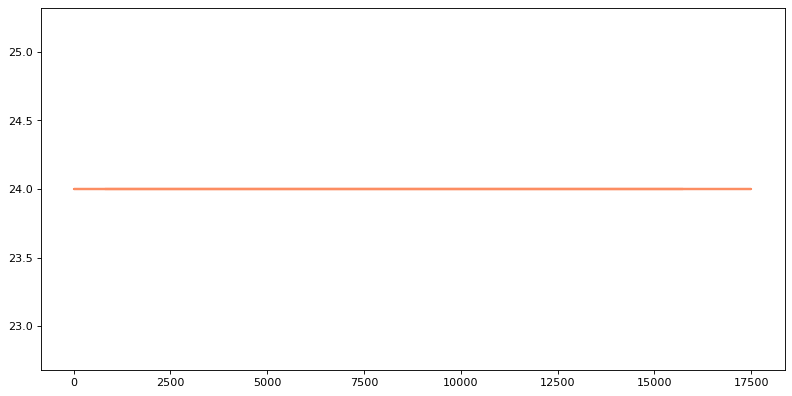

In [45]:
# produce a time series plot
import seaborn as sns
colors = sns.color_palette("Set2")
left = 0
right = 800

plt.figure(1,figsize=(12, 6), dpi=80)
# plt.plot(Y_VoD_test.index[left:right], Y_VoD_test.iloc[left:right], color=colors[0], label="Measured")
plt.plot(Y_VoD_test.index[left:right], Y_VoD_pred[left:right], color=colors[1], label="Estimation", linewidth=2)
plt.plot(Y_VoD_test.index[left:right], [Y_VoD_test.iloc.mean()]*(right-left), color=colors[2], label="Naive Estimation", linewidth=2)
plt.xlabel("Time index")
plt.ylabel("Response time (milliseconds)")
plt.legend()
plt.show()

In [41]:
sns.displot(Y_VoD_test, x='DispFrames',binwidth=1,stat="density")
plt.xlim(left=10)

ValueError: Could not interpret value `DispFrames` for parameter `x`

(-10.0, 10.0)

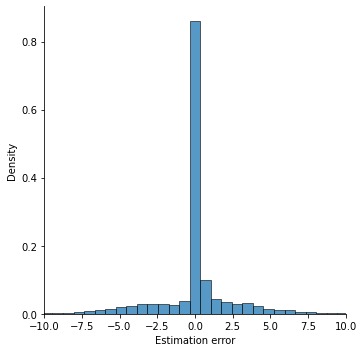

In [186]:
sns.displot(Y_VoD_test-Y_VoD_pred, x='DispFrames',binwidth=0.7,stat="density")
plt.xlabel('Estimation error')
plt.xlim([-10, 10])

(-0.004, 0.03)

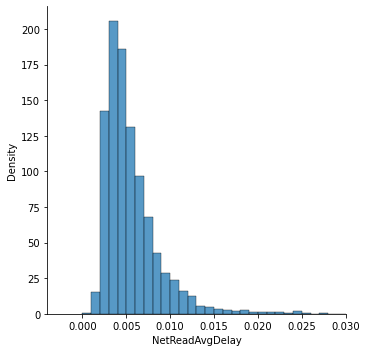

In [184]:
sns.displot(Y_VoD_test, x='NetReadAvgDelay',binwidth=0.001,stat="density")
plt.xlim(right=0.03)

(-0.02, 0.02)

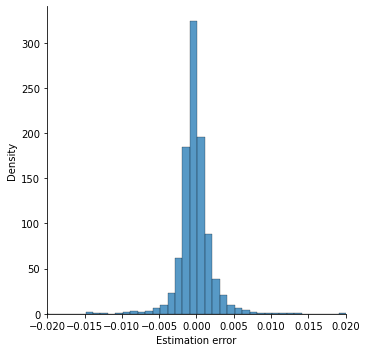

In [189]:
sns.displot(Y_VoD_test-Y_VoD_pred, x='NetReadAvgDelay',binwidth=0.001,stat="density")
plt.xlabel('Estimation error')
plt.xlim([-0.02, 0.02])

(49.1356, 70.0)

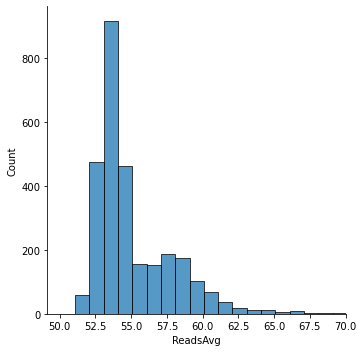

In [176]:
sns.displot(Y_KV_test, x='ReadsAvg',binwidth=1)
plt.xlim(right=70)

(-15.0, 15.0)

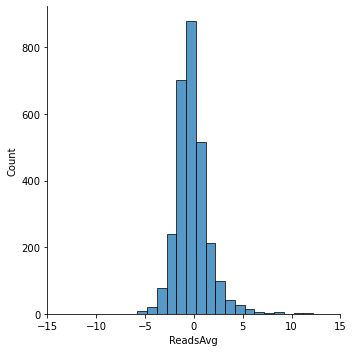

In [192]:
sns.displot(Y_KV_test-Y_KV_pred, x='ReadsAvg',binwidth=1)
plt.xlim([-15, 15])

(97.0696, 150.0)

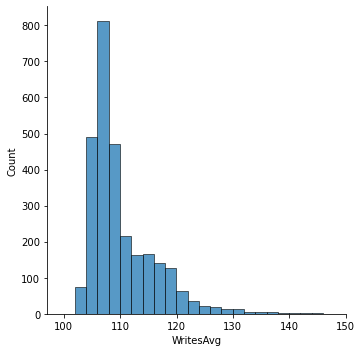

In [174]:
sns.displot(Y_KV_test, x='WritesAvg',binwidth=2)
plt.xlim(right=150)

(-15.0, 15.0)

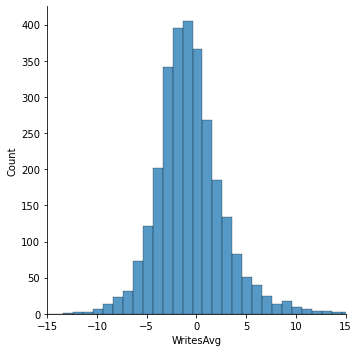

In [195]:
sns.displot(Y_KV_test-Y_KV_pred, x='WritesAvg',binwidth=1)
plt.xlim([-15,15])